In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif

from Libreria.cargar_configbd import cargar_configbd

In [3]:
# Configurar pandas para mostrar todas las filas y columnas
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [4]:
# Conectar a la base de datos PostgreSQL
conn = cargar_configbd.conectar_base_datos('conf_bd.txt')
# Crear un cursor para ejecutar consultas
cur = conn.cursor()

In [5]:
cur.execute(f"SELECT * FROM datos_uda_reglas_sept2023;")
# Obtener los resultados de la consulta
rows = cur.fetchall()

df_modos = pd.DataFrame(rows.copy(), columns=[desc[0] for desc in cur.description])

num_elementos_por_grupo = df_modos.groupby('etiqueta').size()
print(num_elementos_por_grupo)

etiqueta
AUTOMOVIL    72
BICICLETA    72
BUS          72
CAMINATA     72
dtype: int64


In [81]:
#--------------------------- Metodos de Cluster

In [6]:
def KMEANS(data, features, n_clusters):
    X = data.copy()[features]

    # Aplicar el algoritmo de K-means con el número seleccionado de clusters (k)
    model = KMeans(n_clusters=n_clusters, random_state=42, init='k-means++')  # Basado en los resultados del metodo del codo
    y_means = model.fit_predict(X)

    # Asignar las etiquetas de cluster de vuelta a los datos originales
    data.loc[:, 'cluster'] = y_means

    return data.copy()

def HDBSCAN(data, features, eps, min_samples):
    X = data.copy()[features]

    # Instanciar y ajustar el modelo DBSCAN
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    y_scan = dbscan.fit_predict(X)

    # Asignar las etiquetas de cluster de vuelta a los datos originales
    data.loc[:, 'cluster'] = y_scan

    return data.copy()

In [7]:
def graficar_clusters(data, features):

    # PCA
    pca = PCA(n_components=2)
    x_pca = pca.fit_transform(data[features]) 
    results_pca = pd.DataFrame(np.column_stack([x_pca[:,0], x_pca[:,1], data.to_numpy()[:, -1]]), 
                        columns=["x", "y", "modos"])

    # TSNE
    tsne = TSNE(n_components=2, perplexity=10)  # Adjust perplexity as needed
    x_tsne = tsne.fit_transform(data[features]) 
    results_tsne = pd.DataFrame(np.column_stack([x_tsne[:,0],x_tsne[:,1], data.to_numpy()[:, -1]]), 
                        columns=["x", "y", "modos"])

    # Crear una figura y ejes para los subplots
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # Gráfico de PCA
    sns.scatterplot(data=results_pca, x="x", y="y", hue="modos", palette="tab10", ax=axs[0])
    axs[0].set_title('PCA')

    # Gráfico de t-SNE
    sns.scatterplot(data=results_tsne, x="x", y="y", hue="modos", palette="tab10", ax=axs[1])
    axs[1].set_title('t-SNE')

    # Ajustar los subplots
    plt.tight_layout()

    # Mostrar el gráfico
    plt.show()

In [8]:
data = df_modos.copy()

In [9]:
def normalize_data(X):
    scaler = MinMaxScaler()
    X_normalized = scaler.fit_transform(X)
    X_normalized_df = pd.DataFrame(X_normalized, columns=X.columns)
    return X_normalized_df

# Extraer las características (X) y las etiquetas (y) del DataFrame
X = normalize_data(data.iloc[:, 3:-1])  # Todas las filas, todas las columnas excepto la última
y = data.iloc[:, -1]   # Todas las filas, solo la última columna

In [10]:
# Aplica la selección de características univariadas con f_classif
k_value = 29
selector = SelectKBest(score_func=f_classif, k=k_value)  # Por ejemplo, seleccionaremos las 7 mejores características
X_selected = selector.fit_transform(X, y)

# Obtén los índices de las características seleccionadas ordenadas por importancia
selected_feature_indices = np.argsort(selector.scores_)[::-1][:k_value]

# Obtén las características seleccionadas ordenadas por importancia
selected_features = X.columns[selected_feature_indices]

# Imprime las características seleccionadas en orden de importancia
print(selected_features)

Index(['mean_speed', 'p75_speed', 'median_speed', 'p25_speed', 'max_speed',
       'max_time_stop', 'mean_time_stop', 'p75_time_stop', 'var_time_stop',
       'min_aceleration', 'median_time_stop', 'p25_time_stop', 'var_bearing',
       'max_aceleration', 'p25_aceleration', 'stops', 'min_speed',
       'median_aceleration', 'min_bearing', 'max_bearing', 'p75_aceleration',
       'min_time_stop', 'var_speed', 'mean_aceleration', 'p25_bearing',
       'var_aceleration', 'p75_bearing', 'median_bearing', 'mean_bearing'],
      dtype='object')


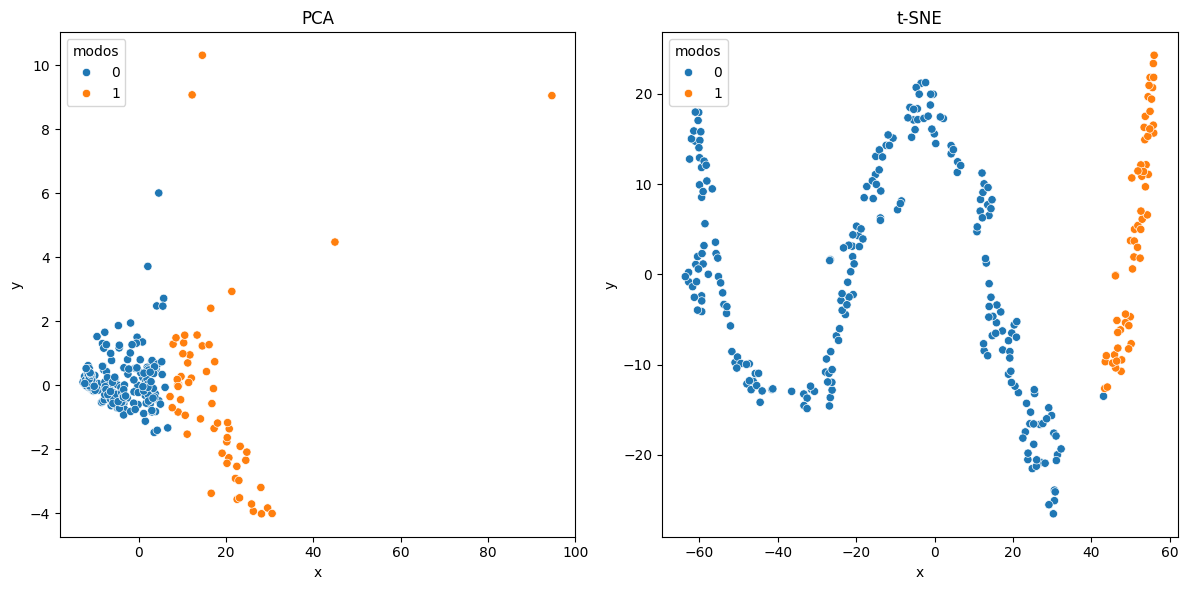

In [11]:
kmeans_features = selected_features[:3]
kmeans_clustering = KMEANS(data.copy(), features=kmeans_features, n_clusters=2)
graficar_clusters(data=kmeans_clustering, features=kmeans_features)

In [12]:
# Obtener el cluster al que pertenece cada modo
cluster_por_modo = kmeans_clustering.groupby('etiqueta')['cluster'].agg(lambda x: x.mode()[0])
print(cluster_por_modo)

etiqueta
AUTOMOVIL    1
BICICLETA    0
BUS          0
CAMINATA     0
Name: cluster, dtype: int32


In [ ]:
# HDBSCAN

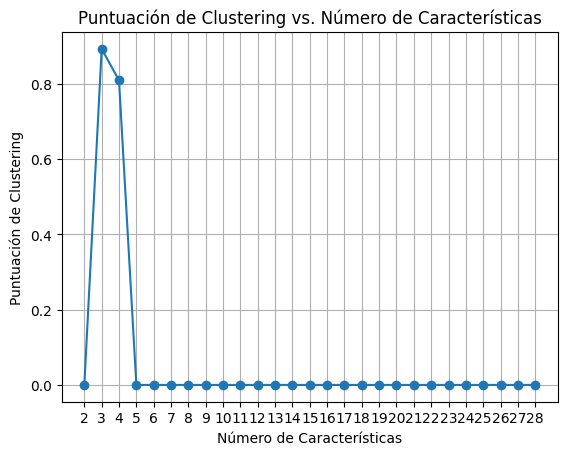

Numero caracteristicas: 3
Precision clustering: 0.8923611111111112


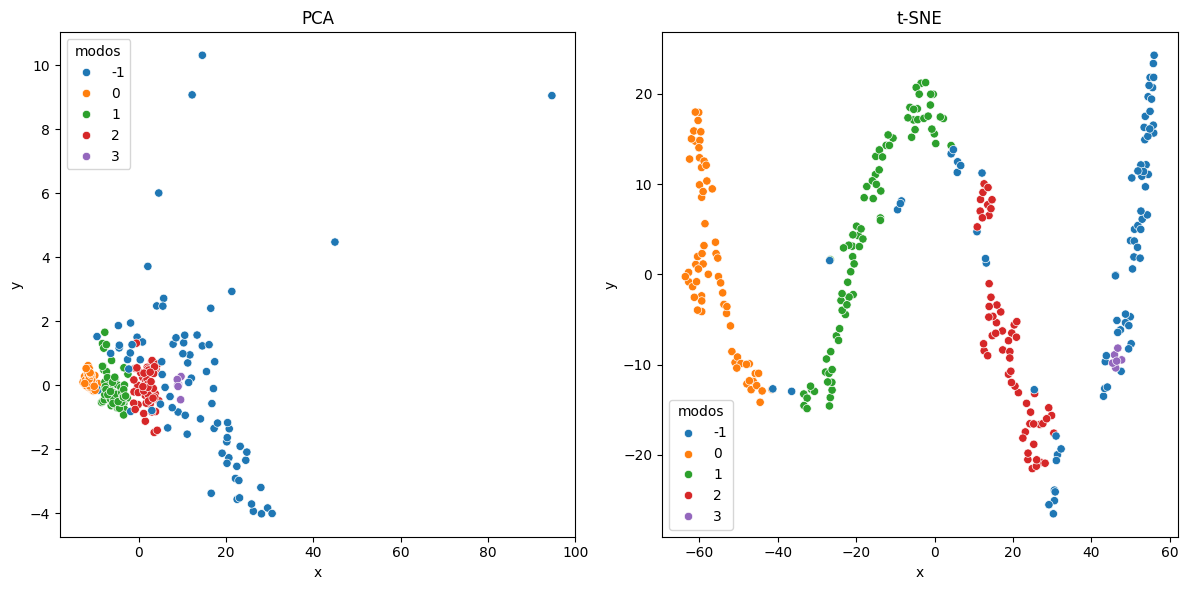

In [12]:
scores = []
caracteristicas = []
for i in range(2, 29):
    
    hdbscan_features = selected_features[:i]
    hdbscan_clustering = HDBSCAN(data.copy(), features=hdbscan_features, eps=0.9, min_samples=6)

    caracteristicas.append(i)
    scores.append(cluster_score(etiquetas=hdbscan_clustering['etiqueta'], clusters=hdbscan_clustering['cluster'], n_clusters=4))

graficar_scores_features(caracteristicas=caracteristicas, scores=scores)

hdbscan_features = selected_features[:caracteristicas[scores.index(max(scores))]]
hdbscan_clustering = HDBSCAN(data.copy(), features=hdbscan_features, eps=0.9, min_samples=6)

print(f"Numero caracteristicas: {caracteristicas[scores.index(max(scores))]}")
print(f"Precision clustering: {cluster_score(etiquetas=hdbscan_clustering['etiqueta'], clusters=hdbscan_clustering['cluster'], n_clusters=4)}")
graficar_clusters(data=hdbscan_clustering, features=hdbscan_features)

In [46]:
#pd.concat([X,y], axis=1).head(5)

In [50]:
# Analizar los clusters obtenidos
for cluster_id in range(2):  # Iterar sobre cada cluster
    cluster_data = data[data['cluster'] == cluster_id]
    print("Cluster", cluster_id)
    print(cluster_data.describe())  # Mostrar estadísticas descriptivas del cluster


Cluster 0
           tripid      segid  p25_speed  p75_speed  max_speed  min_speed  \
count   86.000000  86.000000  86.000000  86.000000  86.000000  86.000000   
mean    28.906977   1.918605   2.224365   3.606257   5.451015   0.763058   
std     27.119616   1.550826   1.551028   2.336167   3.391607   0.810395   
min      1.000000   1.000000   0.144112   0.303065   0.354444  -0.385952   
25%     13.250000   1.000000   0.785852   1.485061   2.256155   0.212360   
50%     20.000000   1.000000   1.900849   3.571808   5.529459   0.495696   
75%     36.500000   2.000000   3.654153   5.361042   7.254654   0.942153   
max    120.000000   8.000000   5.185053  10.574669  16.014030   3.130057   

       mean_speed  median_speed  var_speed  skewness_speed  ...  p75_bearing  \
count   86.000000     86.000000  86.000000       83.000000  ...    86.000000   
mean     2.951479      2.907830   1.985170        0.132654  ...   244.018058   
std      1.843069      1.920388   2.781711        1.046292  ...  